# Using Reddit's API for Classifying Subreddit Posts

This notebook regards the classification of geocaching and IWantToLearn subreddit posts from Reddit using Natural Language Processing techniques. For the workflow of obtaining the posts using webscraping techniques, please refer to the Jupyter Notebook "Project 3 Webscraping.ipynb". This project was segmented into two to prevent from re-running webscraping code.



Problem statement: What characteristics of a post on Reddit contribute most to what subreddit it belongs to?

### Library Imports

In [1]:
# Data cleaning/handling
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
%matplotlib inline

# NLP specific libraries
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction import stop_words
import re
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Modeling Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

### Bring in Dataset of Posts scraped from Reddit

In [2]:
df = pd.read_csv('./reddit_posts.csv')

In [3]:
df['subreddit'].value_counts()

IWantToLearn    1000
geocaching      1000
Name: subreddit, dtype: int64

We can see that there are an even 1000 posts scraped from Reddit from our Webscraping efforts.

## Text Cleaning Tools

In [3]:
# using regular expressions to remove punctuation in a function
def no_punct(string):
    return re.sub("[.,😯?😊!’\";^+`:*'()-@”“=>_$&<~%|{}\[\]]", " ", string)

In [4]:
# Create a function to clean any column or to feed into a word vectorizer as an analyzer parameter
def clean_func(column):
    
    #remove puntuation with punctuation removal function
    column = no_punct(column)
    
    #lowercase
    column = column.lower()
    
    return column

In [5]:
# Function that utilizes lemmatizing and a general Regex to remove punctuation

def preprocess(text):
    # instantiate lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # lowercase
    text = text.lower()
    
    # words only Regex, removes punctuation
    text = re.sub("[^A-Za-z]", " ", text)
    
    # lemmatize
    text = lemmatizer.lemmatize(text)
    
    return text

## Data cleaning and Exploratory Data Analysis

In [6]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [7]:
df.shape

(1995, 3)

In [8]:
df.describe().T

,count,unique,top,freq
text,1364,1364,"For a guy I'm rather emotional, I want to get ...",1
title,1995,1989,IWTL how to improve my logical thinking and pr...,2
subreddit,1995,2,geocaching,999


In [10]:
df.groupby('subreddit').describe().T

subreddit                                          IWantToLearn  \
text  count                                                 890   
      unique                                                890   
      top     I don't think I'm really particularly shy or a...   
      freq                                                    1   
title count                                                 996   
      unique                                                990   
      top                           I want to learn how to sing   
      freq                                                    2   

subreddit                                            geocaching  
text  count                                                 474  
      unique                                                474  
      top     I was going  for the World Turtle souvenir yes...  
      freq                                                    1  
title count                                                 999  
      unique                                                999  
      top                                 Trying to get started  
      freq                                                    1

#### Examining duplicate Titles

In [11]:
df['title'].value_counts().sort_values(ascending=False).head(10)

IWTL how to play the piano                                      2
IWTL how to improve my logical thinking and problem solving.    2
IWTL how to meditate                                            2
I want to learn to speak intellectually.                        2
I want to learn how to sing                                     2
IWTL how to sleep on my back                                    2
IWTL how to be honest without being a complete dick             1
Sneaky Decoy Camera Geocache!                                   1
What phone do you use?                                          1
IWTL estimating project cost and design fast.                   1
Name: title, dtype: int64

In [12]:
df[df['title']=='IWTL how to sleep on my back']

,text,title,subreddit
1220,My whole life I’ve been sleeping on my front a...,IWTL how to sleep on my back,IWantToLearn
1906,It is really difficult for me to fall asleep w...,IWTL how to sleep on my back,IWantToLearn


Not a duplicate, just a similar title.

In [13]:
df[df['title']=='IWTL how to play the piano']

,text,title,subreddit
1021,Any and all advice are welcome. (Iwtl easy ico...,IWTL how to play the piano,IWantToLearn
1212,So I've finally decided I'm going to make use ...,IWTL how to play the piano,IWantToLearn


Ok, text body is different.

In [14]:
df[df['title']=='I want to learn how to sing']

,text,title,subreddit
1573,I never had proper training on singing but I k...,I want to learn how to sing,IWantToLearn
1733,Long short story I can't afford a vocal coach....,I want to learn how to sing,IWantToLearn


Ok, text body is different.

In [15]:
df[df['title']=='IWTL how to meditate']

,text,title,subreddit
1284,I'm trying to learn to meditate but I'm not su...,IWTL how to meditate,IWantToLearn
1403,I want to try it out but I don't know where to...,IWTL how to meditate,IWantToLearn


Ok, text body is different.

In [16]:
df[df['title']=='I want to learn to speak intellectually.']

,text,title,subreddit
1009,I am awkwardly uncomfortable speaking out loud...,I want to learn to speak intellectually.,IWantToLearn
1979,I am awkwardly uncomfortable speaking out loud...,I want to learn to speak intellectually.,IWantToLearn


In [17]:
df['text'].iloc[1009]

'I am awkwardly uncomfortable speaking out loud about anything that I don’t know much about.  I constantly feel like my vocabulary is not where I want it to be.  I’m in college and I feel like I write like an 8th grader.  I say thinks like “like” and “dude” and “that’s what she said” a lot and I can’t seem to stop.  How do I change this?  Before you guys tell me to read more books, what exact books should I be reading?  Any other tips are welcomed.'

In [18]:
df['text'].iloc[1979]

'I am awkwardly uncomfortable speaking out loud about anything that I don’t know much about.  I constantly feel like my vocabulary is not where I want it to be.  I’m in college and I feel like I write like an 8th grader.  I say things like “like” and “dude” and “that’s what she said” a lot and I can’t seem to stop.  How do I change this?  Before you guys tell me to read more books, what exact books should I be reading?  Any other tips are welcomed.'

In [19]:
len(df['text'].iloc[1009])

451

In [20]:
len(df['text'].iloc[1979])

451

In [21]:
diff = []
for char in df['text'].iloc[1009]:
    if char not in df['text'].iloc[1979]:
        diff.append(char)
print(diff)

[]


These are duplicates even though I ran `.drop_duplicates` I can find no difference between the two posts so I will drop one arbitrarily anyway.

In [7]:
df.drop(1979, axis='index', inplace=True)

In [23]:
df[df['title']=='IWTL how to improve my logical thinking and problem solving.']

,text,title,subreddit
1002,"Hi guys, are there any good courses, games or ...",IWTL how to improve my logical thinking and pr...,IWantToLearn
1049,"Hi guys, are there any good courses, games or ...",IWTL how to improve my logical thinking and pr...,IWantToLearn


In [24]:
df['text'].iloc[1002]

'Hi guys, are there any good courses, games or exercises to improve my logical thinking and problem solving ?\nHow can i improve them ?\nThanks in Advance.'

In [25]:
df['text'].iloc[1049]

'Hi guys, are there any good courses, games or exercises ti improve mi logical thinking and problem solving ?\nHow can i improve them ?\nThanks in Advance.'

This is almost a verbatum text description but we can see that there were a few typos. What this means is that the redditor posted this thread and then edited it, but the Webscraper picked up both postings. In this case, drop the first post so as not to bias the models on the mytyped words and double count or weight the rest.

In [8]:
df.drop(1049, axis='index', inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
# Check to see that the two duplicates were removed.
df.shape

(1993, 3)

With the removal of duplicates, the new dataframe is 1993 posts long.

In [9]:
# Create boolean masks to examine geocaching and IWantToLearn subreddits separately.
geocaching = df['subreddit'] == 'geocaching'
iwtl = df['subreddit'] == 'IWantToLearn'

#### Examining null values

In [29]:
df.isnull().sum()

text         631
title          0
subreddit      0
dtype: int64

In [30]:
df[geocaching].isnull().sum()

text         525
title          0
subreddit      0
dtype: int64

In [31]:
df[iwtl].isnull().sum()

text         106
title          0
subreddit      0
dtype: int64

About half of the geocaching posts do not have text in the post description, while only 10% of IWantToLearn posts do not. What this could mean is that IWantToLearn redditors are more willing to go into detail in their posts while geocaching redditors do not or post links.

In [10]:
# Fill empty text posts with 'NA'
df.fillna('NA', inplace=True)

### Examining Title and Text by number of words in each

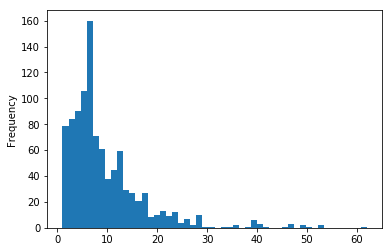

In [33]:
# Look at length of geocaching title
geo_title_length = df[geocaching]['title'].map(clean_func)
geo_title_length = geo_title_length.str.split()
geo_title_length = geo_title_length.apply(len)

# Plot as a histogram
geo_title_length.plot(bins=50, kind='hist');

In [34]:
geo_title_length.describe()

count    999.000000
mean       9.554555
std        8.033421
min        1.000000
25%        4.000000
50%        7.000000
75%       12.000000
max       62.000000
Name: title, dtype: float64

Mostly distributed under 10 words but really skewed with a long tail. So there are only a few outlier titles that are really long.

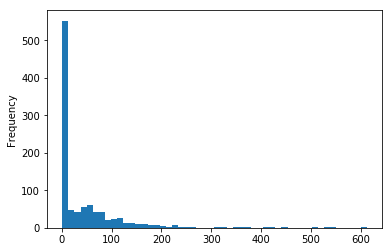

In [35]:
# Look at length of geocaching text
geo_text_length = df[geocaching]['text'].map(clean_func)
geo_text_length = geo_text_length.str.split()
geo_text_length = geo_text_length.apply(len)

geo_text_length.plot(bins=50, kind='hist');

Many posts have no text, or very short text bodies. But there is a much more longer skew with the tail on the right. Since text bodies can be longer, there are a few posts that are even longer than the longest titles

In [36]:
geo_text_length.describe()

count    999.000000
mean      41.844845
std       70.957119
min        1.000000
25%        1.000000
50%        1.000000
75%       61.000000
max      612.000000
Name: text, dtype: float64

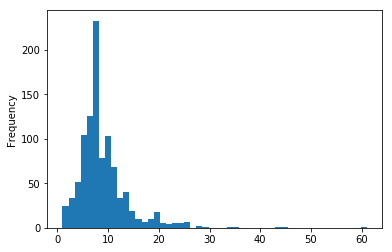

In [37]:
# Look at length of IWantToLearn title
iwtl_title_length = df[iwtl]['title'].map(clean_func)
iwtl_title_length = iwtl_title_length.str.split()
iwtl_title_length = iwtl_title_length.apply(len)

iwtl_title_length.plot(bins=50, kind='hist');

In [38]:
iwtl_title_length.describe()

count    994.000000
mean       8.823944
std        5.089154
min        1.000000
25%        6.000000
50%        8.000000
75%       10.000000
max       61.000000
Name: title, dtype: float64

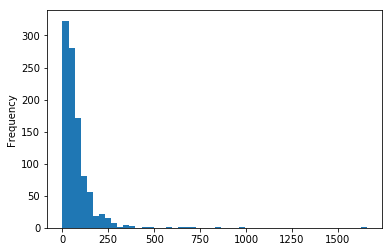

In [39]:
# Look at length of IWantToLearn text
iwtl_text_length = df[iwtl]['text'].map(clean_func)
iwtl_text_length = iwtl_text_length.str.split()
iwtl_text_length = iwtl_text_length.apply(len)

iwtl_text_length.plot(bins=50, kind='hist');

In [40]:
iwtl_text_length.describe()

count     994.000000
mean       75.691147
std        99.553647
min         1.000000
25%        27.000000
50%        54.000000
75%        92.000000
max      1657.000000
Name: text, dtype: float64

At a glance it looks like IWantToLearn titles and Geocaching titles are mostly distributed in less than 10 words. IWantToLearn posts have fewer "title only" type posts and tend to be longer than the geocaching posts that do have text.

## Creating Corpora

Keep title and post text separate before CountVector/TF-IDF and create models from each separately. Later, I will explore whether combining both title and post text make a significant difference.

In [11]:
title_corpus = df['title']
text_corpus = df['text']

#### Since I want to predict a binary variable - subreddit `0` for geocaching and `1` for IWantToLearn.

In [12]:
y = df['subreddit'].map({'geocaching': 0, 'IWantToLearn': 1})

## Train-Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42)

## Natural Language Processing

#### Use `CountVectorizer` or `TfidfVectorizer` from scikit-learn to create features from the thread titles and descriptions (NOTE: Not all threads have a description)
- Examine using count or binary features in the model
- Re-evaluate your models using these. Does this improve the model performance? 
- What text features are the most valuable? 

### Master stopword list

In [14]:
# Create a master stopword list from both stopword lists
custom_stopwords = list(set(stopwords.words('english') + list(stop_words.ENGLISH_STOP_WORDS)))

# Add 'na' because it indicates an empty text post
custom_stopwords.extend(['na'])

In [14]:
len(custom_stopwords)

379

In [15]:
# Create a stopword list that only takes out 'na'
no_na = ['na']

## Count Vectorizer

In [17]:
# Instantiate countvectorizer
cvec = CountVectorizer(stop_words=custom_stopwords)

In [18]:
title_counts = cvec.fit_transform(X_train['title'])

In [19]:
counts = pd.DataFrame(title_counts.todense(), columns=cvec.vocabulary_)

In [71]:
# See what top counted words appear in the Titles
top_title_words_c = counts.sum().sort_values(ascending=False)[0:20]
top_title_words_c

shine           560
looks           143
feed            121
figure           91
fighting         84
explorist        71
fl               57
exports          47
added            43
collaborated     36
calendar         31
single           30
met              29
extra            29
binge            28
receiving        27
etiquette        27
automotive       25
pay              24
boys             24
dtype: int64

In [24]:
text_counts = cvec.fit_transform(X_train['text'])

In [25]:
counts2 = pd.DataFrame(text_counts.todense(), columns=cvec.vocabulary_)

In [70]:
# See what top counted words appear in the Text post
top_text_words_c = counts2.sum().sort_values(ascending=False)[0:20]
top_text_words_c

electro          505
advertised       376
fucking          365
oregon           271
gender           262
geocachingnsw    253
tutorials        250
matlab           220
fork             186
2017             176
em               173
ol               173
haha             154
21               148
mainly           145
mladen           143
distractible     141
intonation       140
openly           137
worlds           137
dtype: int64

Note of interest that words that are part of each subreddit's culture do not appear in the top 20 or even top 50 lists. Words such as "geocache" and "iwtl".

## Term Frequency - Inverse Document Frequency

#### Does it make a difference?

#### Title

In [28]:
# Instantiate 
tvec = TfidfVectorizer(stop_words=custom_stopwords)

In [29]:
title_tf = tvec.fit_transform(X_train['title'])

In [30]:
title_tf_fit = pd.DataFrame(title_tf.todense(), columns=tvec.vocabulary_)

In [31]:
# See that there were a few changes to top words when inverse document frequency is applied
top_title_words_tf = title_tf_fit.sum().sort_values(ascending=False)[0:20]
top_title_words_tf

shine           96.182752
looks           39.276772
feed            34.215720
figure          28.322361
fighting        27.203960
explorist       24.345841
fl              17.475491
exports         14.163197
added           14.118537
collaborated    13.954623
met             12.110098
extra           12.033046
single          11.677608
pay             11.657905
calendar        10.943987
receiving       10.621959
etiquette       10.613149
binge           10.331351
20              10.156783
augusta         10.054043
dtype: float64

#### Text

In [33]:
text_tf = tvec.fit_transform(X_train['text'])

In [34]:
text_tf_fit = pd.DataFrame(text_tf.todense(), columns=tvec.vocabulary_)

In [35]:
top_text_words_tf = text_tf_fit.sum().sort_values(ascending=False)[0:20]
top_text_words_tf

electro          34.715441
advertised       29.653051
fucking          29.457742
oregon           24.700624
tutorials        20.429052
gender           20.376762
geocachingnsw    18.942764
2017             18.252320
mladen           17.776934
matlab           17.671167
ol               17.613669
fork             16.223027
em               15.973496
intonation       15.262113
haha             14.821731
distractible     13.402571
wheel            13.181590
openly           13.070319
mainly           13.066385
21               12.800917
dtype: float64

### Comparison between CountVectorizer and TF-IDF

In [51]:
pd.DataFrame([top_title_words_c, top_title_words_tf]).T

,0,1
shine,560.0,96.182752
looks,143.0,39.276772
feed,121.0,34.215720
figure,91.0,28.322361
fighting,84.0,27.203960
explorist,71.0,24.345841
fl,57.0,17.475491
exports,47.0,14.163197
added,43.0,14.118537
collaborated,36.0,13.954623


The top 10 title words are the same between both vectorizers but the TF-IDF made "20" and "augusta" of interest while lowering the importance of "automotive" and "boys". "met", "pay", and "extra" became more of interest than "calendar", "single". 

In [52]:
pd.DataFrame([top_text_words_c, top_text_words_tf]).T

,0,1
electro,505.0,34.715441
advertised,376.0,29.653051
fucking,365.0,29.457742
oregon,271.0,24.700624
gender,262.0,20.376762
geocachingnsw,253.0,18.942764
tutorials,250.0,20.429052
matlab,220.0,17.671167
fork,186.0,16.223027
2017,176.0,18.252320


The top text words had more movement in terms of importance from CountVectorizer to TF-IDF, but only one new word difference between the two top lists. The top 5 remained the same. "geocachingnsw" and "tutorials" changed places.

For performance reasons, I am choosing to use TF-IDF as a preprocessing vectorizer over CountVectorizer.

### Test out different parameters for TF-IDF using GridSearchCV and the MultinomialNB

Commenting out after having run the following code to prevent it from running from an accidental "Run All" command and hanging all computer processing power.

### Title TF-IDF

In [57]:
pipeline = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('model', MultinomialNB())
])

In [58]:
params = {
    'tvec__stop_words': ['english', custom_stopwords],
    'tvec__analyzer': ['word', preprocess],
    'tvec__max_df': [250, 500, 750],
    'tvec__min_df': [1, 2, 3],
    'tvec__ngram_range': [(1, 1), (1, 3)]
}

In [59]:
gs = GridSearchCV(pipeline, param_grid=params, cv=5)
gs.fit(X_train['title'], y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tvec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...e,
        vocabulary=None)), ('model', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'tvec__stop_words': ['english', ['hundred', 'nowhere', "doesn't", 'across', 't', 'my', 'm', 'we', 'wherever', 'name', 'her', 've', "that'll", 'give', 'about', 'ourselves', "shouldn't", 'made', 'via', 'found', 'so', 'etc', 'it', 'by', 'show', 'your', 'on', 'move', 'the', 'us', 'below', 'd..., 'tvec__max_df': [250, 500, 750], 'tvec__min_df': [1, 2, 3], 'tvec__ngram_range': [(1, 1), (1, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_tra

In [60]:
gs.best_score_

0.9497991967871486

Best score on titles: 0.950

In [61]:
gs.best_params_

{'tvec__analyzer': 'word',
 'tvec__max_df': 500,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 3),
 'tvec__stop_words': ['hundred',
  'nowhere',
  "doesn't",
  'across',
  't',
  'my',
  'm',
  'we',
  'wherever',
  'name',
  'her',
  've',
  "that'll",
  'give',
  'about',
  'ourselves',
  "shouldn't",
  'made',
  'via',
  'found',
  'so',
  'etc',
  'it',
  'by',
  'show',
  'your',
  'on',
  'move',
  'the',
  'us',
  'below',
  'd',
  'himself',
  'detail',
  'one',
  'didn',
  'further',
  'neither',
  'go',
  'none',
  'forty',
  'here',
  'after',
  'even',
  'alone',
  'often',
  'same',
  'at',
  'shan',
  'a',
  'very',
  'weren',
  'five',
  'anyway',
  'cry',
  'ltd',
  'otherwise',
  'where',
  'too',
  'couldnt',
  'i',
  'whereafter',
  'seem',
  'throughout',
  'sixty',
  'herself',
  'its',
  'own',
  'together',
  'take',
  'three',
  "hasn't",
  "didn't",
  'from',
  'never',
  'yourself',
  'are',
  'most',
  'thin',
  'was',
  'still',
  'fill',
  'will',
  'nor',


Best parameters on titles:

`{'tvec__analyzer': 'word',
 'tvec__max_df': 500,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 3),
 'tvec__stop_words': custom_stopwords}`

In [62]:
model = gs.best_estimator_

In [66]:
model.score(X_test['title'], y_test)

0.8937875751503006

There is a 10% drop in accuracy score from training to testing sets, indicating some amount of overfitting and high variance.

#### Best TF-IDF
Using these parameters, fit and transform the title corpus.

In [16]:
best_tvec = TfidfVectorizer(analyzer='word', max_df=500, min_df=1, ngram_range=(1,3), stop_words=custom_stopwords)

In [17]:
best_title_tf = best_tvec.fit_transform(X_train['title'])

In [18]:
best_title_tf_fit = pd.DataFrame(best_title_tf.todense(), columns=best_tvec.vocabulary_)

### Text TF-IDF

In [72]:
pipeline = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('model', MultinomialNB())
])

In [93]:
params = {
    'tvec__stop_words': ['english', custom_stopwords],
    'tvec__analyzer': ['word'],
    'tvec__max_df': [250, 500, 750],
    'tvec__min_df': [3, 4, 5],
    'tvec__ngram_range': [(1, 1)]
}

In [94]:
gs = GridSearchCV(pipeline, param_grid=params, cv=5)
gs.fit(X_train['text'], y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tvec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...e,
        vocabulary=None)), ('model', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'tvec__stop_words': ['english', ['hundred', 'nowhere', "doesn't", 'across', 't', 'my', 'm', 'we', 'wherever', 'name', 'her', 've', "that'll", 'give', 'about', 'ourselves', "shouldn't", 'made', 'via', 'found', 'so', 'etc', 'it', 'by', 'show', 'your', 'on', 'move', 'the', 'us', 'below', 'd...['word'], 'tvec__max_df': [250, 500, 750], 'tvec__min_df': [3, 4, 5], 'tvec__ngram_range': [(1, 1)]},
       pre_dispatch='2*n_jobs', refit=True, return_tra

In [95]:
gs.best_score_

0.9183400267737617

Best score on text: 0.918

In [96]:
gs.best_params_

{'tvec__analyzer': 'word',
 'tvec__max_df': 500,
 'tvec__min_df': 4,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': ['hundred',
  'nowhere',
  "doesn't",
  'across',
  't',
  'my',
  'm',
  'we',
  'wherever',
  'name',
  'her',
  've',
  "that'll",
  'give',
  'about',
  'ourselves',
  "shouldn't",
  'made',
  'via',
  'found',
  'so',
  'etc',
  'it',
  'by',
  'show',
  'your',
  'on',
  'move',
  'the',
  'us',
  'below',
  'd',
  'himself',
  'detail',
  'one',
  'didn',
  'further',
  'neither',
  'go',
  'none',
  'forty',
  'here',
  'after',
  'even',
  'alone',
  'often',
  'same',
  'at',
  'shan',
  'a',
  'very',
  'weren',
  'five',
  'anyway',
  'cry',
  'ltd',
  'otherwise',
  'where',
  'too',
  'couldnt',
  'i',
  'whereafter',
  'seem',
  'throughout',
  'sixty',
  'herself',
  'its',
  'own',
  'together',
  'take',
  'three',
  "hasn't",
  "didn't",
  'from',
  'never',
  'yourself',
  'are',
  'most',
  'thin',
  'was',
  'still',
  'fill',
  'will',
  'nor',


In [97]:
model = gs.best_estimator_

In [98]:
model.score(X_test['text'], y_test)

0.9178356713426854

Best parameters on text:

`{'tvec__analyzer': 'word',
 'tvec__max_df': 500,
 'tvec__min_df': 4,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'custom_stopwords'}`
 
 By comparison between the two GridSearches, we see that though they differ in max_df, min_df, and ngram range both can agree on the use of the default `'word'` analyzer and the use of 'na' as the only stopword. However, I am still going to use the custom_stopwords to limit the number of word features.

#### Best TF-IDF
Using these parameters, fit and transform the text corpus.

In [19]:
best_tvec = TfidfVectorizer(analyzer='word', max_df=500, ngram_range=(1,1), min_df= 4, stop_words=custom_stopwords)

In [20]:
best_text_tf = best_tvec.fit_transform(X_train['text'])

In [21]:
best_text_tf_fit = pd.DataFrame(best_text_tf.todense(), columns=best_tvec.vocabulary_)

### Combine the vectorized Title and Text tables into one table of features

In [22]:
best_tf_corpus = pd.concat([best_title_tf_fit, best_text_tf_fit], axis=1)

In [23]:
best_tf_corpus.shape

(1993, 18006)

# Predicting subreddits

#### The baseline accuracy for this model is the percentage of the majority class on the dataset.

In [23]:
df['subreddit'].value_counts(normalize=True)

geocaching      0.501254
IWantToLearn    0.498746
Name: subreddit, dtype: float64

What this means is that we expect the model to have at least an accuracy of 50% to be better than random guessing.

## Random Forests

#### Using a `RandomForestClassifier` model to predict which subreddit a given post belongs to.

In [67]:
# Instantiate
rf = RandomForestClassifier()

rf.fit(X_train['title'], y_train)

ValueError: could not convert string to float: "ITWL How to make friends at college, when I'm disabled and socially impaired"

In [27]:
rf.score(X_train['title'], y_train)

0.999330655957162

In [28]:
rf.score(X_test['title'], y_test)

0.9639278557114228

With all the model defaults, a Random Forest Classifier performs pretty highly. We can see evidence of overfitting in the drop in accuracy from the training set to the test set.

In [29]:
[rf.feature_importances_]

[array([0., 0., 0., ..., 0., 0., 0.])]

In [31]:
y_pred = rf.predict(X_test)

In [32]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.96      0.97      0.96       250
          1       0.97      0.96      0.96       249

avg / total       0.96      0.96      0.96       499



In [15]:
rf_coef = pd.DataFrame(rf.feature_importances_.T, columns=best_tf_corpus.columns)
rf_coef.head()

NameError: name 'rf' is not defined

# Delete Later
#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy of the model, as well as any other metrics you feel are appropriate. 
- **Bonus**: Use `GridSearchCV` with `Pipeline` to optimize your `CountVectorizer`/`TfidfVectorizer` and classification model.

In [19]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

In [20]:
params = {}

In [21]:
gs = GridSearchCV(pipeline, param_grid=params, cv=5)
gs.fit(X_train, y_train)

ValueError: Number of labels=1195 does not match number of samples=3

In [ ]:
pipelines = Pipeline([
    ('tfidf', ##best_tfidf),
    ('multi', MultinomialNB())
])

In [ ]:
params = {}

In [ ]:
gs = GridSearchCV(pipeline, param_grid=params, cv=5)
gs.fit(X_train, y_train)

In [ ]:
pipelines = Pipeline([
    ('tfidf', ##best_tfidf)
    ('log_reg', LogisticRegression())
])

In [ ]:
params = {}

In [ ]:
gs = GridSearchCV(pipeline, param_grid=params, cv=5)
gs.fit(X_train, y_train)

# Model Pipeline

In [ ]:
pipelines = {
    'rf': make_pipeline(TfidfVectorizer(), RandomForestClassifier()),
    'lr': make_pipeline(TfidfVectorizer(), LogisticRegression()),
    'multi': make_pipeline(TfidfVectorizer(), MultinomialNB())
}

### Hyperparameter dictionary of all the specific tunings

In [ ]:
# TF-IDF
tfidf_hyperparameters = {
    'tf'
}



# Random Forest
rf_hyperparameters = {
    'rf__n_estimators': [],
    'rf__max_depth': [],
}

# Logistic Regression
lr_hyperparameters = {
    'lr__': [],
    
}

# Multinomial Naive-Bayes
multi_hyperparameters = {
    'multi__': [],
}


In [ ]:
# Dictionary linking named models to respective hyperparameter dictionary
hyperparameters = {
    'rf': rf_hyperparameters,
    'log_reg': lr_hyperparameters,
    'multi': multi_hyperparameters, 
}

In [ ]:
# Make an empty dictionary of fitted models 
fitted_models = {}
# Loop through models in pipelines, tuning each one and saving it to fitted_models

for name , pipeline in pipelines.items():

    # Create cross-validation object
    model = GridSearchCV(pipeline , hyperparameters[name], cv=5, n_jobs=-1)
    model.fit(X_train, y_train)
    fitted_models[name] = model
    print('Done fitting: ' name)

In [ ]:
for name in fitted_models.items():
    print(name, model.best_score_)

# Idea: Have separate branch where combine Title and Post Text then run count vectorizer / TF-IDF here

In [32]:
corpus = df['title'] + ' ' + df['text']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(corpus, y, random_state=42)

In [57]:
pipeline = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('model', MultinomialNB())
])

In [58]:
params = {
    'tvec__stop_words': ['english', custom_stopwords],
    'tvec__analyzer': ['word', preprocess],
    'tvec__max_df': [250, 500, 750],
    'tvec__min_df': [1, 2, 3],
    'tvec__ngram_range': [(1, 1), (1, 3)]
}

In [59]:
gs = GridSearchCV(pipeline, param_grid=params, cv=5)
gs.fit(X_train['title'], y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tvec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...e,
        vocabulary=None)), ('model', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'tvec__stop_words': ['english', ['hundred', 'nowhere', "doesn't", 'across', 't', 'my', 'm', 'we', 'wherever', 'name', 'her', 've', "that'll", 'give', 'about', 'ourselves', "shouldn't", 'made', 'via', 'found', 'so', 'etc', 'it', 'by', 'show', 'your', 'on', 'move', 'the', 'us', 'below', 'd..., 'tvec__max_df': [250, 500, 750], 'tvec__min_df': [1, 2, 3], 'tvec__ngram_range': [(1, 1), (1, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_tra

In [60]:
gs.best_score_

0.9497991967871486

# Executive Summary
---


Is there a difference in learning and outdoor exploration?

Both involve curiosity and wandering around in odd places, both on the internet and in the real world.